# Melanoma Detection with Convolutional Neural Network

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


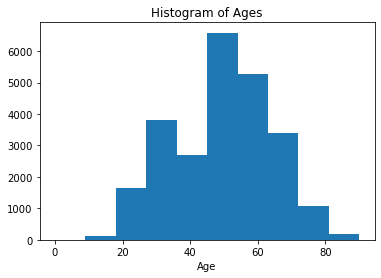

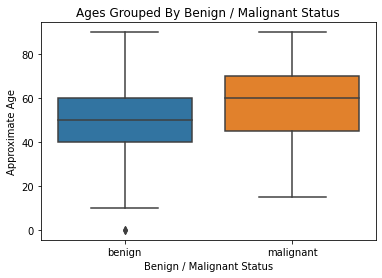

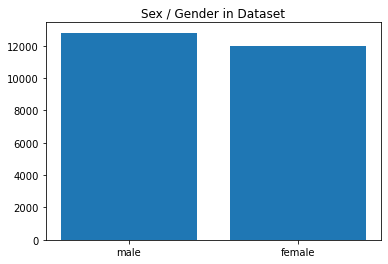

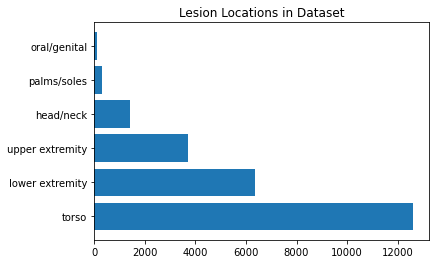

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



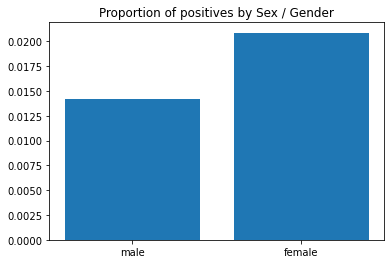



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



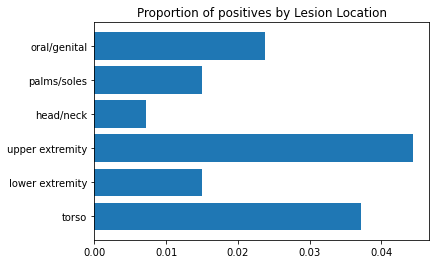

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## CNN Mark \#2

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cpu
Number of devices: 36


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# helper function for padding images one at a time
def pad2d_4k6k(_image):

    rows = _image.shape[1]
    cols = _image.shape[2]

    top = np.ceil((4000 - rows)/2).astype('int')
    bottom = np.floor((4000 - rows)/2).astype('int')
    right = np.ceil((6000 - cols)/2).astype('int')
    left = np.floor((6000 - cols)/2).astype('int')

    pad_func = nn.ConstantPad2d((left, right, top, bottom), 0)
    
    return pad_func(_image)


# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
    
        pad_image = pad2d_4k6k(_image)
        
        image_list.append(torch.unsqueeze(pad_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 2

tr_transf = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "train.csv"), 
                            num_samples=2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [10]:
class Net(nn.Module):
    def __init__(self):
        '''
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        '''
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 15, 5)
        self.conv2_bn = nn.BatchNorm2d(15)
        self.conv3 = nn.Conv2d(15, 25, 5)
        self.conv3_bn = nn.BatchNorm2d(25)
        self.conv4 = nn.Conv2d(25, 40, 5)
        self.conv4_bn = nn.BatchNorm2d(40)
        self.conv5 = nn.Conv2d(40, 50, 5)
        self.conv5_bn = nn.BatchNorm2d(50)
        self.conv6 = nn.Conv2d(50, 60, 5)
        self.conv6_bn = nn.BatchNorm2d(60)
        self.conv7 = nn.Conv2d(60, 75, 5)
        self.conv7_bn = nn.BatchNorm2d(75)
        self.conv8 = nn.Conv2d(75, 85, 5)
        self.conv8_bn = nn.BatchNorm2d(85)
        self.conv9 = nn.Conv2d(85, 100, 5)
        self.conv9_bn = nn.BatchNorm2d(100)
        self.fc1 = nn.Linear(100*7*3, 100) 
        self.fc2 = nn.Linear(100, 85)
        self.fc3 = nn.Linear(85, 1)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        x = self.pool(F.relu(self.conv6_bn(self.conv6(x))))
        x = self.pool(F.relu(self.conv7_bn(self.conv7(x))))
        x = self.pool(F.relu(self.conv8_bn(self.conv8(x))))
        x = self.pool(F.relu(self.conv9_bn(self.conv9(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


In [11]:
load_weights = False
create_new_weights = False
PATH = './melanoma_cnn2.pth'

if load_weights:
    print('Loading the pre-trained CNN weights.')
    
    # network weights load
    net = Net()
    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=24408, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new CNN weights.')
    mini_batch = 0
    net = Net().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=0.01)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=24408, gamma=0.5)
    
    

In [12]:
learn_weights = False

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 24408

        # print every 25 mini-batch
        if i % 25 == 0:
            print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
            print(f'[Epoch {epoch}, Batch {mini_batch % 24408}] Loss: {running_loss / (i+1)}\n')

        # save every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)

        # validate every 1000 mini-batch
        if i % 1000 == 0:

            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))

            precision, recall, thresholds = metrics.precision_recall_curve(ground_truths, probs)
            f1scores = 2 * (precision * recall) / (precision + recall)
            opt_thresh = thresholds[np.argmax(f1scores)]
            opt_preds = probs > opt_thresh


            print("Using max F1-Score threshold, the confusion matrix is:\n", metrics.confusion_matrix(ground_truths, opt_preds))
            
            
            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 12000 == 0:
            uPATH = f'./melanoma_cnn2_{epoch}e_{mini_batch % 24408}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 0


# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [13]:
batch_size = 2

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign


In [14]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [18]:
os.listdir('./saved_weights2/')

['melanoma_cnn2_0e_12000b.pth',
 'melanoma_cnn2_0e_24000b.pth',
 'melanoma_cnn2_1e_11592b.pth',
 'melanoma_cnn2_1e_23592b.pth',
 'melanoma_cnn2_2e_11184b.pth',
 'melanoma_cnn2_2e_23184b.pth',
 'melanoma_cnn2_3e_10776b.pth',
 'melanoma_cnn2_3e_22776b.pth']

Loading: melanoma_cnn2_0e_12000b.pth

	 Processing Image #1 ... Running Time 15.409677028656006
	 Current Testing Loss: 0.7459040880203247

******* Final Testing Loss: 0.7459040880203247 *******

Loading: melanoma_cnn2_0e_24000b.pth

	 Processing Image #1 ... Running Time 12.151910305023193
	 Current Testing Loss: 0.7224329710006714

******* Final Testing Loss: 0.7224329710006714 *******

Loading: melanoma_cnn2_1e_11592b.pth

	 Processing Image #1 ... Running Time 11.32901382446289
	 Current Testing Loss: 0.707209587097168

******* Final Testing Loss: 0.707209587097168 *******

Loading: melanoma_cnn2_1e_23592b.pth

	 Processing Image #1 ... Running Time 14.621922731399536
	 Current Testing Loss: 0.68284010887146

******* Final Testing Loss: 0.68284010887146 *******

Loading: melanoma_cnn2_2e_11184b.pth

	 Processing Image #1 ... Running Time 12.409684419631958
	 Current Testing Loss: 0.7226412892341614

******* Final Testing Loss: 0.7226412892341614 *******

Loading: melanoma_cnn2_2e_2

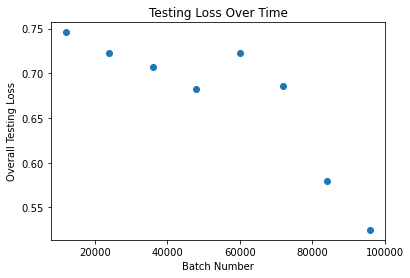

In [17]:
weight_fnames = os.listdir('./saved_weights2/')
weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights2/{fname}', map_location=device)
    
    # network weights load
    net = Net().to(device)
    net.load_state_dict(checkpoint['model_state_dict'])    
    criterion = nn.BCELoss()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 100 == 0:
                print(f"\t Processing Image #{2*i + 1} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')
                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')
    
    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))         
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results2/results_cnn2_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

In [ ]:
# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results2/')
    
    for fname in res_fnames:
        with open(f'./saved_results2/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"])    
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [ ]:
best_batch_size = 7777


with open(f'./saved_results2/results_cnn2_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F1-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()